In [59]:
import os
import librosa
import pandas as pd

# Set your dataset path
dataset_path = "data/all_emotion"

# List all .wav files
wav_files = [f for f in os.listdir(dataset_path) if f.endswith('.wav')]

# Collect metadata
metadata = []
for file in wav_files:
    file_path = os.path.join(dataset_path, file)
    y, sr = librosa.load(file_path, sr=None)  # Load the audio
    duration = librosa.get_duration(y=y, sr=sr)  # Get duration
    metadata.append({
        "file_name": file,
        "file_path": file_path,
        "sample_rate": sr,
        "duration_sec": duration
    })

# Convert metadata to a DataFrame
df_metadata = pd.DataFrame(metadata)

df_metadata.head()

/var/folders/4q/wlkm41x57nv0n4qhnyv84kjc0000gn/T/ipykernel_82099/2885745582.py:15: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=None)  # Load the audio
/opt/anaconda3/envs/tensorflow/lib/python3.11/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


,file_name,file_path,sample_rate,duration_sec
0,h04 (3).wav,data/all_emotion/h04 (3).wav,44100,2.556054
1,d03 (5)b.wav,data/all_emotion/d03 (5)b.wav,44100,7.115873
2,h14 (3).wav,data/all_emotion/h14 (3).wav,44100,2.214354
3,d17 (3).wav,data/all_emotion/d17 (3).wav,44100,5.600000
4,d07 (3).wav,data/all_emotion/d07 (3).wav,44100,3.032562


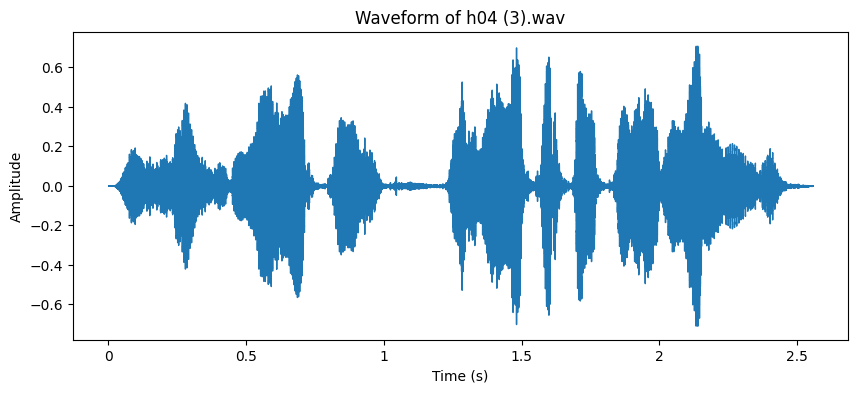

In [60]:
import matplotlib.pyplot as plt

# Plot the waveform of the first file
file_to_plot = metadata[0]['file_path']
y, sr = librosa.load(file_to_plot, sr=None)

plt.figure(figsize=(10, 4))
librosa.display.waveshow(y, sr=sr)
plt.title(f"Waveform of {metadata[0]['file_name']}")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

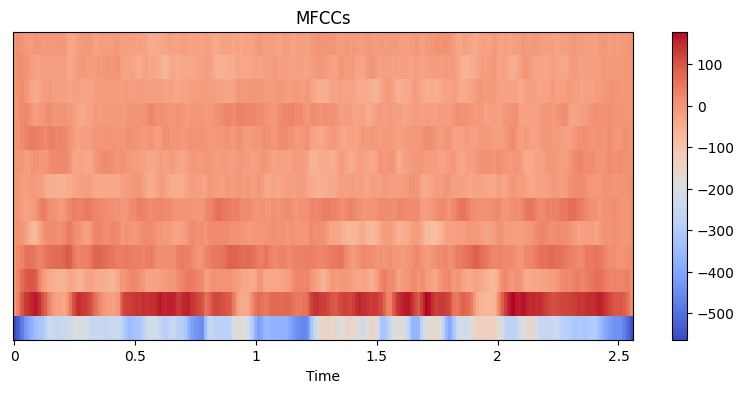

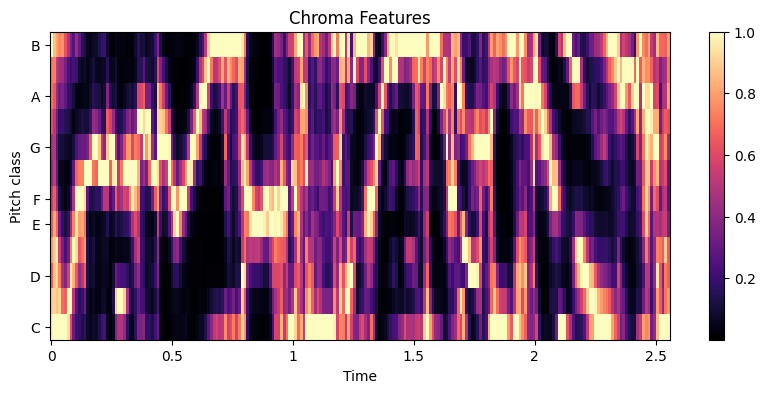

In [61]:
# Extract features for the first file
mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
chroma = librosa.feature.chroma_stft(y=y, sr=sr)

# Plot MFCCs
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfcc, x_axis='time', sr=sr)
plt.colorbar()
plt.title("MFCCs")
plt.show()

# Plot Chroma Features
plt.figure(figsize=(10, 4))
librosa.display.specshow(chroma, x_axis='time', y_axis='chroma', sr=sr)
plt.colorbar()
plt.title("Chroma Features")
plt.show()

In [62]:
# Extract emotion labels from file names
df_metadata['emotion'] = df_metadata['file_name'].str[0]  # Assumes the first letter of the file name indicates emotion

# Map single-letter codes to emotion names (if available)
emotion_mapping = {
    'a': 'angry',
    'h': 'happy',
    's': 'sad',
    'd': 'disgust',
    'f': 'fear'
}
df_metadata['emotion'] = df_metadata['emotion'].map(emotion_mapping)

# Summarize duration by emotion
emotion_summary = df_metadata.groupby("emotion")["duration_sec"].describe()

# Display the summary to the user

emotion_summary.head(5)

,count,mean,std,min,25%,50%,75%,max
emotion,,,,,,,,
angry,121.0,3.585928,1.262586,1.531882,2.600000,3.376621,4.297891,7.410476
disgust,122.0,4.560497,1.419934,1.900000,3.473067,4.470556,5.470278,9.728277
fear,120.0,3.746690,1.483154,0.981179,2.727874,3.354490,4.533356,9.000000
happy,119.0,4.024161,1.550632,1.936508,2.892551,3.600000,4.665567,9.530476
sad,123.0,4.554217,2.082229,0.000000,3.146224,4.069070,4.974569,12.734853


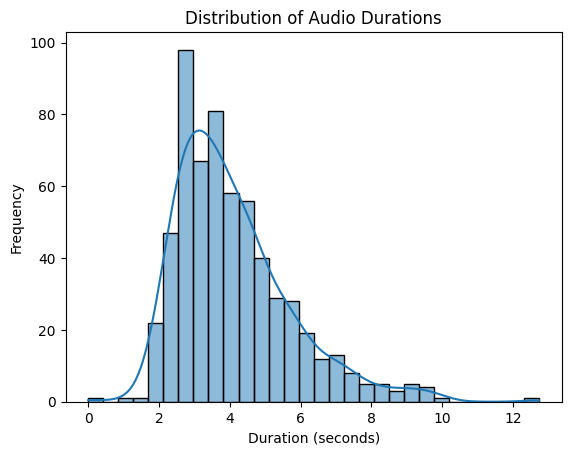

In [63]:
import seaborn as sns

# Histogram of durations
sns.histplot(df_metadata['duration_sec'], bins=30, kde=True)
plt.title("Distribution of Audio Durations")
plt.xlabel("Duration (seconds)")
plt.ylabel("Frequency")
plt.show()

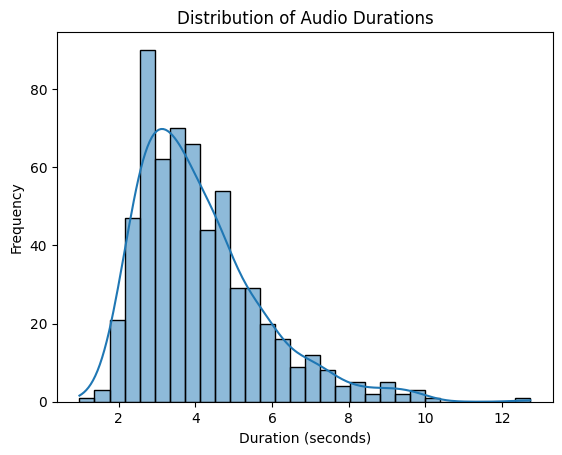

In [64]:
# Remove entries with a duration of 0.0 seconds
df_metadata = df_metadata[df_metadata['duration_sec'] > 0.0]
# Histogram of durations
sns.histplot(df_metadata['duration_sec'], bins=30, kde=True)
plt.title("Distribution of Audio Durations")
plt.xlabel("Duration (seconds)")
plt.ylabel("Frequency")
plt.show()

In [65]:
import librosa
import librosa.display
import numpy as np
import os
import matplotlib.pyplot as plt

# Function to preprocess a single audio file
def preprocess_audio(file_path, target_sr=22050):
    # Load the audio file
    y, sr = librosa.load(file_path, sr=target_sr)
    
    # Noise reduction (simple)
    y_mean = np.mean(y)
    y = y - y_mean  # Center the signal around zero
    
    # Normalization
    y = librosa.util.normalize(y)
    
    return y, sr

In [66]:
# Function to convert a signal to a Mel Spectrogram
def audio_to_mel_spectrogram(y, sr, n_mels=128, fmax=8000):
    # Create Mel Spectrogram
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, fmax=fmax)
    
    # Convert to log scale for better interpretability
    log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
    
    return log_mel_spec

# Visualize a Mel Spectrogram
def plot_mel_spectrogram(mel_spec, sr):
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mel_spec, sr=sr, x_axis='time', y_axis='mel', cmap='viridis')
    plt.colorbar(format='%+2.0f dB')
    plt.title("Mel Spectrogram")
    plt.xlabel("Time (s)")
    plt.ylabel("Mel Frequency")
    plt.show()

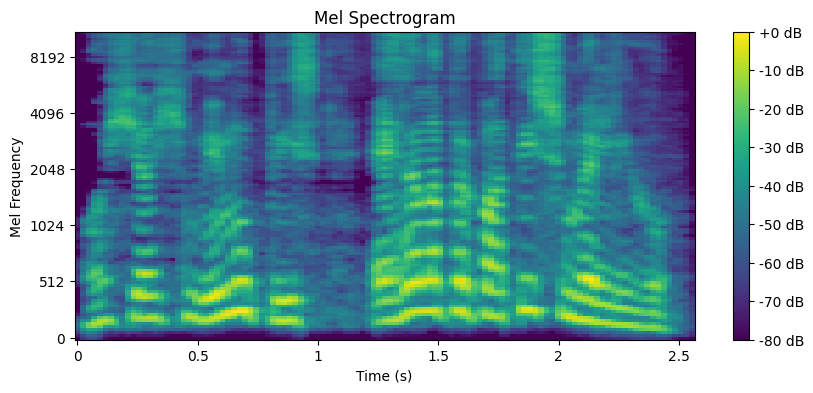

In [67]:
# Ensure your df_metadata contains a 'file_path' column pointing to the audio files
df_metadata['mel_spectrogram'] = None  # Initialize a column for spectrogram data
for index, row in df_metadata.iterrows():
    file_path = row['file_path']
    
    try:
        # Preprocess the audio
        y, sr = preprocess_audio(file_path)
        
        # Convert to Mel Spectrogram
        mel_spec = audio_to_mel_spectrogram(y, sr)
        
        # Store the Mel Spectrogram in the DataFrame
        df_metadata.at[index, 'mel_spectrogram'] = mel_spec

        # Optional: Visualize the spectrogram for the first file
        if index == 0:  # Show the first file for verification
            plot_mel_spectrogram(mel_spec, sr)
    except Exception as e:
        print(f"Error processing file {file_path}: {e}")

In [68]:
preprocessed_data = []
for name, mel_spec in zip(df_metadata['file_name'], df_metadata['mel_spectrogram']):
    if mel_spec is not None:
        preprocessed_data.append({
            "file_name": name,
            "mel_spectrogram": mel_spec
        })
preprocessed_data[0]

{'file_name': 'h04 (3).wav',
 'mel_spectrogram': array([[-80.      , -68.0319  , -62.208282, ..., -78.17905 , -77.77095 ,
         -80.      ],
        [-74.261765, -62.072067, -53.81221 , ..., -62.152496, -62.931248,
         -69.603935],
        [-64.424576, -50.61343 , -44.568123, ..., -50.477104, -59.44271 ,
         -68.411804],
        ...,
        [-80.      , -80.      , -66.72485 , ..., -80.      , -80.      ,
         -80.      ],
        [-80.      , -78.90662 , -65.3465  , ..., -77.892166, -80.      ,
         -80.      ],
        [-80.      , -75.633644, -64.823715, ..., -75.8154  , -80.      ,
         -80.      ]], dtype=float32)}

In [69]:
import matplotlib.pyplot as plt

output_dir = "processed_spectrograms"
os.makedirs(output_dir, exist_ok=True)

for data in preprocessed_data:
    file_name = data["file_name"].replace(".wav", ".png")
    mel_spec = data["mel_spectrogram"]
    
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mel_spec, x_axis='time', y_axis='mel', cmap='viridis')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f"Mel Spectrogram: {file_name}")
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, file_name))
    plt.close()